## Prepare Notebook

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style(
    style="darkgrid", 
    rc={"axes.facecolor": "0.9", "grid.color": "0.8"}
)
sns.set_palette(palette="deep")
sns_c = sns.color_palette(palette="deep")

from statsmodels.tsa.statespace.structural import UnobservedComponents

plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100

%reload_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = "png"

## Generate Sample Data

In [73]:
np.random.seed(1)

min_date = pd.to_datetime("2015-01-01")
max_date = pd.to_datetime("2022-01-01")

data_df = pd.DataFrame(
    data={"date": pd.date_range(start=min_date, end=max_date, freq="M")}
)

n = data_df.shape[0]

def generate_data(n, sigma_eta, sigma_epsilon):
   
    y = np.zeros(n)
    mu = np.zeros(n)
    epsilon = np.zeros(n)
    eta = np.zeros(n)

    for t in range(1, n):
        
        eta[t] = np.random.normal(loc=0.0, scale=sigma_eta)
        mu[t] = mu[t - 1] + eta[t]

        epsilon[t] = np.random.normal(loc=0.0, scale=sigma_epsilon)
        y[t] = mu[t] + epsilon[t]

    return y, mu

sigma_eta = 0.1
sigma_epsilon = 0.1

y, mu = generate_data(n=n, sigma_eta=sigma_eta, sigma_epsilon=sigma_epsilon)

data_df["y"] = y

# Add external regressor.
x = np.random.uniform(low=0.0, high=1.0, size=n)
data_df["x"] = np.where( x > 0.80, x, 0)
# Add seasonal component.
data_df["cs"] = np.sin(2 * np.pi * data_df["date"].dt.dayofyear / 356.5) 
data_df["cc"] = np.cos(3 * np.pi * data_df["date"].dt.dayofyear / 356.5) 
data_df["s"] = data_df["cs"] + data_df["cc"]
# Construct target variable.
data_df["z"] = data_df["y"] + data_df["x"] + data_df["s"]
# Add autoregressive term.
data_df["z"] = data_df["z"] + 0.5 * data_df["z"].shift(1).fillna(0)

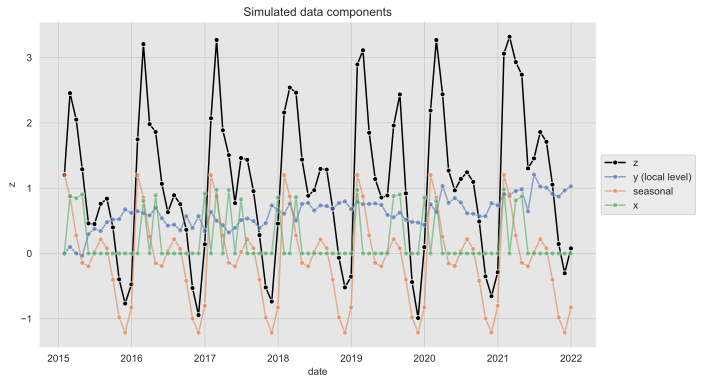

In [67]:
fig, ax = plt.subplots()
sns.lineplot(x="date", y="z", data=data_df, marker="o", markersize=5, color="black", label="z", ax=ax)
sns.lineplot(x="date", y="y", data=data_df, marker="o", markersize=5, color=sns_c[0], alpha=0.6, label="y (local level)", ax=ax)
sns.lineplot(x="date", y="s", data=data_df, marker="o", markersize=5, color=sns_c[1], alpha=0.6, label="seasonal", ax=ax)
sns.lineplot(x="date", y="x", data=data_df, marker="o", markersize=5, color=sns_c[2], alpha=0.6, label="x", ax=ax)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Simulated data components");

In [68]:
# Set date as index.
data_df.set_index("date", inplace=True)
data_df.index = pd.DatetimeIndex(
    data=data_df.index.values,
    freq=data_df.index.inferred_freq
)

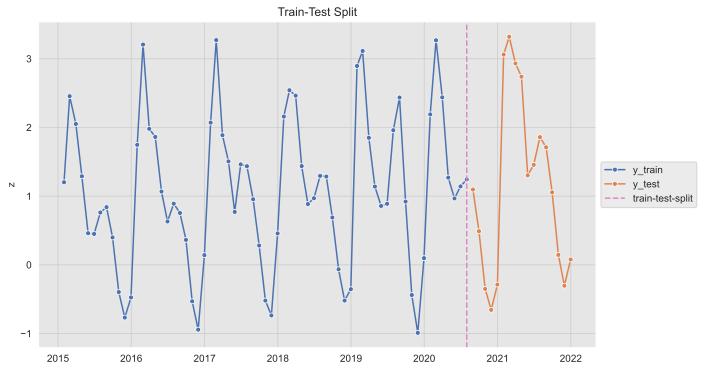

In [69]:
train_test_ratio = 0.80
n_train = int(n * train_test_ratio)
n_test = n - n_train

data_train_df = data_df[: n_train]
data_test_df = data_df[- n_test :]

y_train = data_train_df["z"]
x_train = data_train_df[["x"]]

y_test = data_test_df["z"]
x_test = data_test_df[["x"]]

fig, ax = plt.subplots()
sns.lineplot(x=y_train.index, y=y_train, marker="o", markersize=5, color=sns_c[0], label="y_train", ax=ax)
sns.lineplot(x=y_test.index, y=y_test, marker="o", markersize=5, color=sns_c[1], label="y_test", ax=ax)
ax.axvline(x=x_train.tail(1).index[0], color=sns_c[6], linestyle="--", label="train-test-split")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Train-Test Split");

In [70]:
model_params =  {
    "endog": y_train,
    "exog": x_train,
    "level": "local level",
    "freq_seasonal": [
         {"period": 12, "harmonics": 4}
    ],
    "autoregressive": 1,
    "mle_regression": False,
 }
 
model = UnobservedComponents(**model_params)

result = model.fit(disp=0)

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                Unobserved Components Results                                
=============================================================================================
Dep. Variable:                                     z   No. Observations:                   67
Model:                                   local level   Log Likelihood                 -11.145
                   + stochastic freq_seasonal(12(4))   AIC                             32.291
                                             + AR(1)   BIC                             42.506
Date:                               Sat, 27 Nov 2021   HQIC                            36.261
Time:                                       17:09:28                                         
Sample:                                   01-31-2015                                         
                                        - 07-31-2020                                         
Covariance Type:                                 opg                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
sigma2.irregular             5.48e-08      0.111   4.93e-07      1.000      -0.218       0.218
sigma2.level                   0.0024      0.003      0.740      0.460      -0.004       0.009
sigma2.freq_seasonal_12(4)  9.383e-12      0.000   7.04e-08      1.000      -0.000       0.000
sigma2.ar                      0.0498      0.117      0.424      0.672      -0.180       0.280
ar.L1                          0.2775      0.711      0.390      0.696      -1.115       1.670
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                 0.88
Prob(Q):                              0.63   Prob(JB):                         0.64
Heteroskedasticity (H):               1.86   Skew:                             0.21
Prob(H) (two-sided):                  0.19   Kurtosis:                         2.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

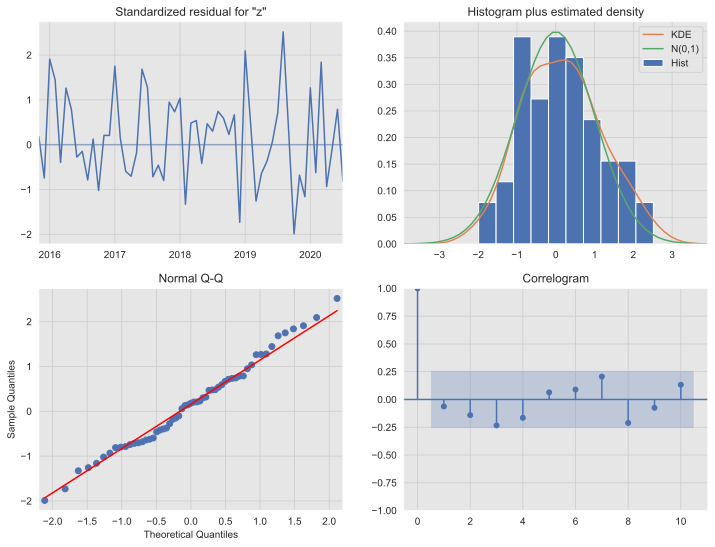

In [71]:
result.plot_diagnostics(figsize=(12, 9));

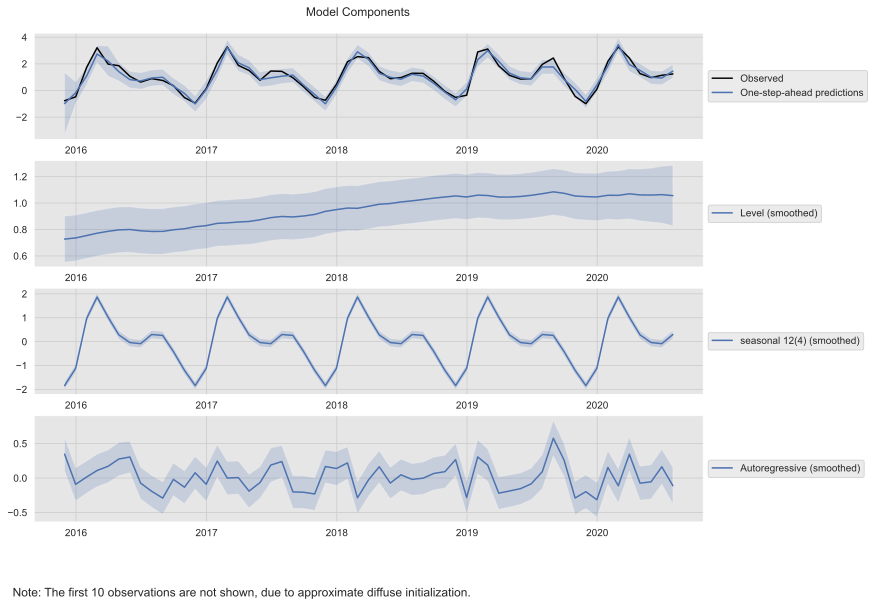

In [74]:
fig = result.plot_components(figsize=(12, 9), alpha=0.05)

for ax in fig.get_axes():
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set(title=None)

fig.suptitle("Model Components", y=0.92);

## PyMC Integration

In [76]:
import arviz as az
import pymc3 as pm
import theano.tensor as tt


class Loglike(tt.Op):

    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, model):
        self.model = model
        self.score = Score(self.model)

    def perform(self, node, inputs, outputs):
        (theta,) = inputs  # contains the vector of parameters
        llf = self.model.loglike(theta)
        outputs[0][0] = np.array(llf)  # output the log-likelihood

    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        (theta,) = inputs  # our parameters
        out = [g[0] * self.score(theta)]
        return out


class Score(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, model):
        self.model = model

    def perform(self, node, inputs, outputs):
        (theta,) = inputs
        outputs[0][0] = self.model.score(theta)

In [77]:
loglike_uc = Loglike(model)

In [78]:
# Set sampling params
ndraws = 4000  # number of draws from the distribution
nburn = 1000  # number of "burn-in points" (which will be discarded)

In [82]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                Unobserved Components Results                                
=============================================================================================
Dep. Variable:                                     z   No. Observations:                   67
Model:                                   local level   Log Likelihood                 -11.145
                   + stochastic freq_seasonal(12(4))   AIC                             32.291
                                             + AR(1)   BIC                             42.506
Date:                               Sat, 27 Nov 2021   HQIC                            36.261
Time:                                       17:14:20                                         
Sample:                                   01-31-2015                                         
                                        - 07-31-2020                                         
Covariance Type:                                 opg                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
sigma2.irregular             5.48e-08      0.111   4.93e-07      1.000      -0.218       0.218
sigma2.level                   0.0024      0.003      0.740      0.460      -0.004       0.009
sigma2.freq_seasonal_12(4)  9.383e-12      0.000   7.04e-08      1.000      -0.000       0.000
sigma2.ar                      0.0498      0.117      0.424      0.672      -0.180       0.280
ar.L1                          0.2775      0.711      0.390      0.696      -1.115       1.670
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                 0.88
Prob(Q):                              0.63   Prob(JB):                         0.64
Heteroskedasticity (H):               1.86   Skew:                             0.21
Prob(H) (two-sided):                  0.19   Kurtosis:                         2.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [98]:
with pm.Model() as pm_model:
    # Priors
    sigma2_irregular = pm.InverseGamma("sigma2.irregular", alpha=2, beta=1)
    sigma2_level = pm.InverseGamma("sigma2.level", alpha=2, beta=1)
    sigma2_freq_seasonal = pm.InverseGamma("sigma2.freq_seasonal_12(4)", alpha=2, beta=1)
    sigma2_ar = pm.InverseGamma("sigma2.ar", alpha=2, beta=1)
    ar_L1 = pm.Uniform("ar.L1", -0.99, 0.99)

    # convert variables to tensor vectors
    theta_uc = tt.as_tensor_variable([
        sigma2_irregular,
        sigma2_level,
        sigma2_freq_seasonal,
        sigma2_ar,
        ar_L1
    ])

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist("likelihood", loglike_uc, observed=theta_uc)

    # Draw samples
    trace_uc = pm.sample(
        draws=ndraws,
        tune=nburn,
        chains=2,
        return_inferencedata=True,
        cores=-1,
        compute_convergence_checks=False,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ar.L1, sigma2.ar, sigma2.freq_seasonal_12(4), sigma2.level, sigma2.irregular]


Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 142 seconds.


In [99]:
pm_model

/var/folders/xv/983bz0q51wbb27tjz2c4r40w0000gn/T/ipykernel_7099/3667271338.py:8: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


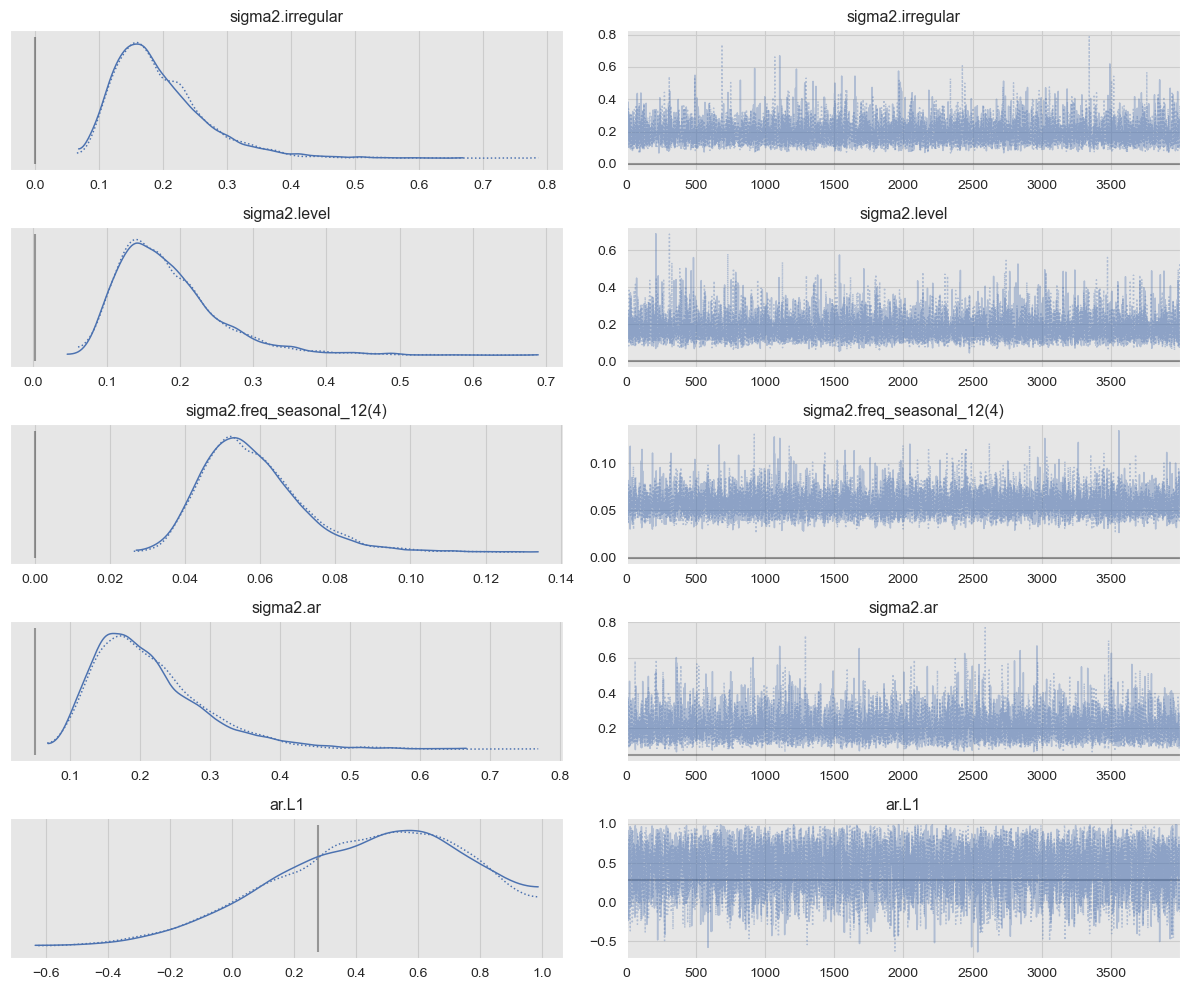

In [100]:
from arviz.utils import Numba
Numba.disable_numba()

az.plot_trace(
    data=trace_uc,
    lines=[(k, {}, [v]) for k, v in dict(result.params).items()]
)
plt.tight_layout()

In [92]:
all_posterior_samples = trace_uc["posterior"].stack(sample=("chain", "draw")).to_array().values

n_samples = 200

posterior_samples = np.apply_along_axis(
    func1d = lambda x: np.random.choice(a=x, size=n_samples),
    axis=1,
    arr=all_posterior_samples
)